In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
from keras.models import Sequential
from keras import Input
from keras.layers import Dense
import warnings
import pandas as pd
import numpy as np

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv("/content/phishing_site_urls.csv")

In [ ]:
data.Label.value_counts()

good    392924
bad     156422
Name: Label, dtype: int64

In [ ]:
df_shuffled = shuffle(data, random_state=42)

In [ ]:
data_size = 5000

In [ ]:
df_used = df_shuffled[:data_size].copy()

In [ ]:
df_used

,URL,Label
452638,tubevector.com/search/?q=erika,good
306476,classmates.com/directory/school/Marian%20Chris...,good
100735,isgsi.com/office/adb/c58c94eccbfb951bd4ba5f2a6...,bad
384460,manufacturersnews.com/executives.asp?start=CEN,good
40436,'9d345009-a-62cb3a1a-s-sites.googlegroups.com/...,bad
...,...,...
448662,topix.com/county/st-louis-mn,good
141499,allenruss.com/,good
464007,whosdatedwho.com/tpx_40341/saira-mohan/,good
166145,doctorno.blogetery.com/2009/10/02/soft-kill-va...,good


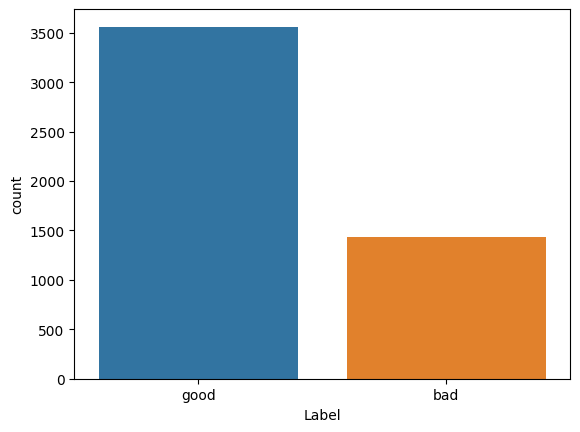

In [ ]:
sns.countplot(data=df_used, x="Label")
plt.show()

In [ ]:
df_used.replace({'good':0, 'bad':1}, inplace=True)

In [ ]:
X = df_used[['URL']].copy()
y = df_used.Label.copy()

In [ ]:
y

452638    0
306476    0
100735    1
384460    0
40436     1
         ..
448662    0
141499    0
464007    0
166145    0
170545    0
Name: Label, Length: 5000, dtype: int64

In [ ]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')
stemmer = SnowballStemmer("english")
cv = CountVectorizer()

In [ ]:
def prepare_data(X) :
    X['text_tokenized'] = X.URL.map(lambda t: tokenizer.tokenize(t))
    X['text_stemmed'] = X.text_tokenized.map(lambda t: [stemmer.stem(word) for word in t])
    X['text_sent'] = X.text_stemmed.map(lambda t: ' '.join(t))
    features = cv.fit_transform(X.text_sent)
    return X, features

In [ ]:
X, features = prepare_data(X)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [ ]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier()
rfc = RandomForestClassifier()
svc = SVC()

In [ ]:
def train_test_model(model, X, y, training_percentage) :
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=1-training_percentage, stratify=y, random_state=42)
    model.fit(trainX, trainY)
    predY = model.predict(testX)
    accuracy = accuracy_score(testY, predY)
    precision = precision_score(testY, predY, pos_label=1)
    recall = recall_score(testY, predY, pos_label=1)
    return accuracy, precision, recall

In [ ]:
training_sizes = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [ ]:
def model_results(model) :
    results = []
    for p in training_sizes :
        results.append(train_test_model(model, features, y, p))
    return pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall'])

In [ ]:
logreg_results = model_results(logreg)
knn_results = model_results(knn)
dtree_results = model_results(dtree)
rfc_results = model_results(rfc)
svc_results = model_results(svc)

In [ ]:
models = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'SVM']
model_results = [logreg_results, knn_results, dtree_results, rfc_results, svc_results]

In [ ]:
accuracies = []
precisions = []
recalls = []
for model in model_results :
    accuracies.append(model.Accuracy.values)
    precisions.append(model.Precision.values)
    recalls.append(model.Recall.values)

In [ ]:
accuracies = pd.DataFrame(np.transpose(accuracies), columns=models, index=training_sizes*100)
precisions = pd.DataFrame(np.transpose(precisions), columns=models, index=training_sizes*100)
recalls = pd.DataFrame(np.transpose(recalls), columns=models, index=training_sizes*100)

In [ ]:
accuracies

,Logistic Regression,KNN,Decision Tree,Random Forest,SVM
10.0,0.830667,0.739778,0.822889,0.845333,0.783111
20.0,0.863500,0.727750,0.850250,0.870750,0.832750
30.0,0.881429,0.726286,0.848857,0.881143,0.847143
40.0,0.885667,0.736000,0.854667,0.889333,0.856333
50.0,0.892400,0.750800,0.864000,0.900800,0.864400
60.0,0.900500,0.750000,0.866000,0.903500,0.872500
70.0,0.909394,0.765490,0.876749,0.900733,0.880746
80.0,0.902000,0.742000,0.880000,0.900000,0.878000
90.0,0.896000,0.738000,0.876000,0.892000,0.872000


In [ ]:
precisions

,Logistic Regression,KNN,Decision Tree,Random Forest,SVM
10.0,0.915625,0.557423,0.766917,0.840547,0.954286
20.0,0.914835,0.526091,0.836386,0.913725,0.925664
30.0,0.920455,0.521548,0.817819,0.920341,0.918440
40.0,0.901235,0.538883,0.803698,0.933116,0.892727
50.0,0.894737,0.564000,0.818487,0.935305,0.889344
60.0,0.917778,0.560976,0.824524,0.948357,0.937158
70.0,0.930233,0.590498,0.832884,0.935385,0.937716
80.0,0.916667,0.546296,0.823077,0.912281,0.932292
90.0,0.933962,0.538922,0.853448,0.941176,0.925532


Text(0, 0.5, 'Accuracy')

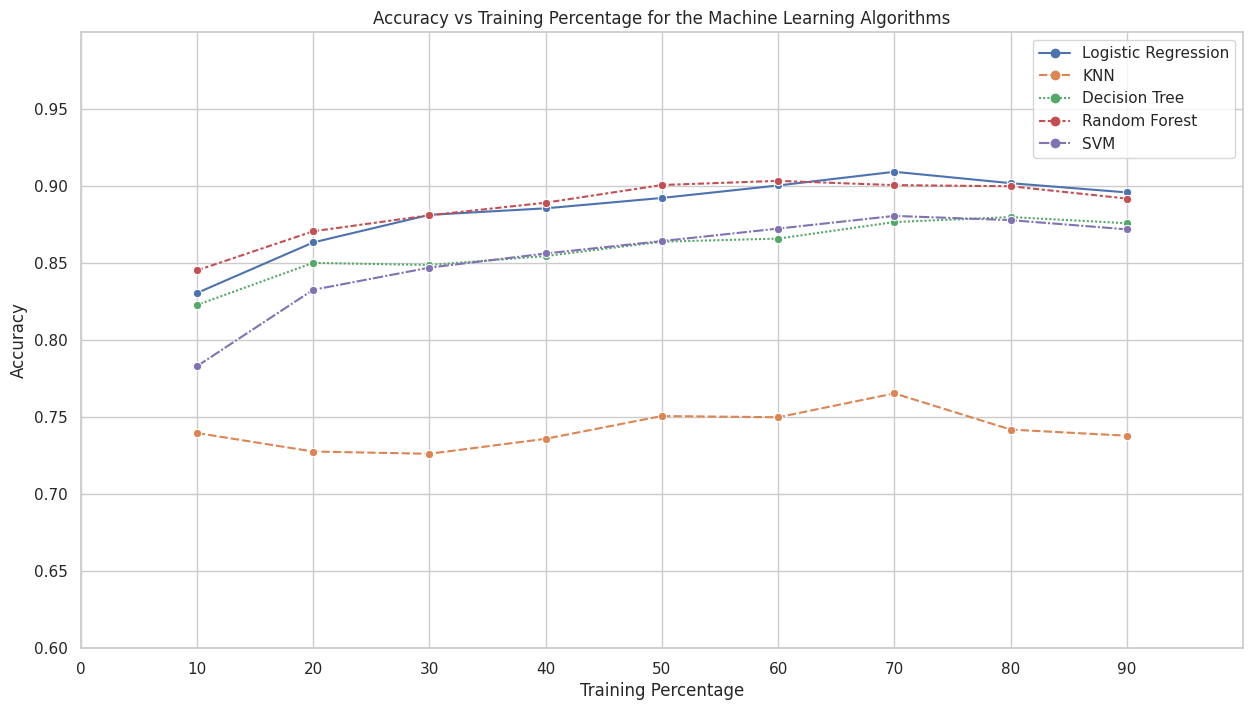

In [ ]:
sns.set(rc={'figure.figsize':(15,8)})
sns.set_style('whitegrid')
g = sns.lineplot(data = accuracies, markers= ['o', 'o', 'o', 'o', 'o'])
g.set(xlim = (0,100), ylim = (0.6,1), xticks = np.arange(0, 100, 10), yticks = np.arange(0.6, 1, 0.05))
g.set_title("Accuracy vs Training Percentage for the Machine Learning Algorithms")
g.set_xlabel("Training Percentage")
g.set_ylabel("Accuracy")

Text(0, 0.5, 'Precision')

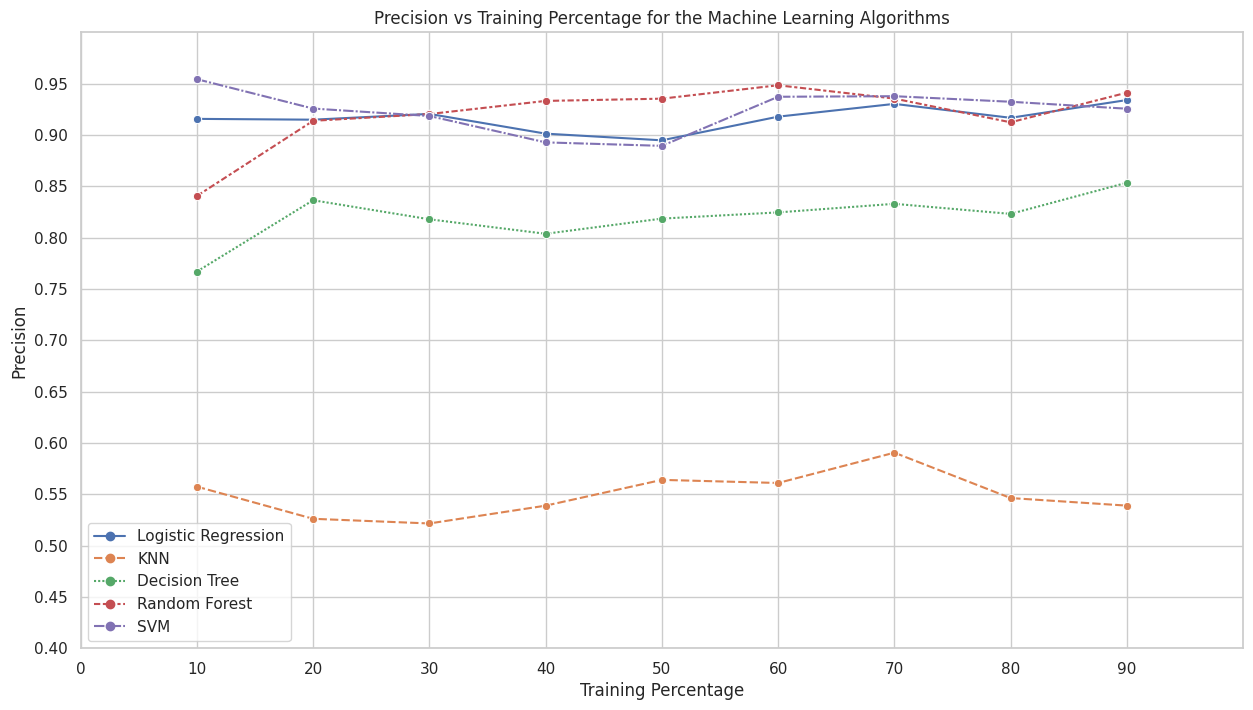

In [ ]:
sns.set(rc={'figure.figsize':(15,8)})
sns.set_style('whitegrid')
g = sns.lineplot(data = precisions, markers= ['o', 'o', 'o', 'o', 'o'])
g.set(xlim = (0,100), ylim = (0.4,1), xticks = np.arange(0, 100, 10), yticks = np.arange(0.4, 1, 0.05))
g.set_title("Precision vs Training Percentage for the Machine Learning Algorithms")
g.set_xlabel("Training Percentage")
g.set_ylabel("Precision")

Text(0, 0.5, 'Recall')

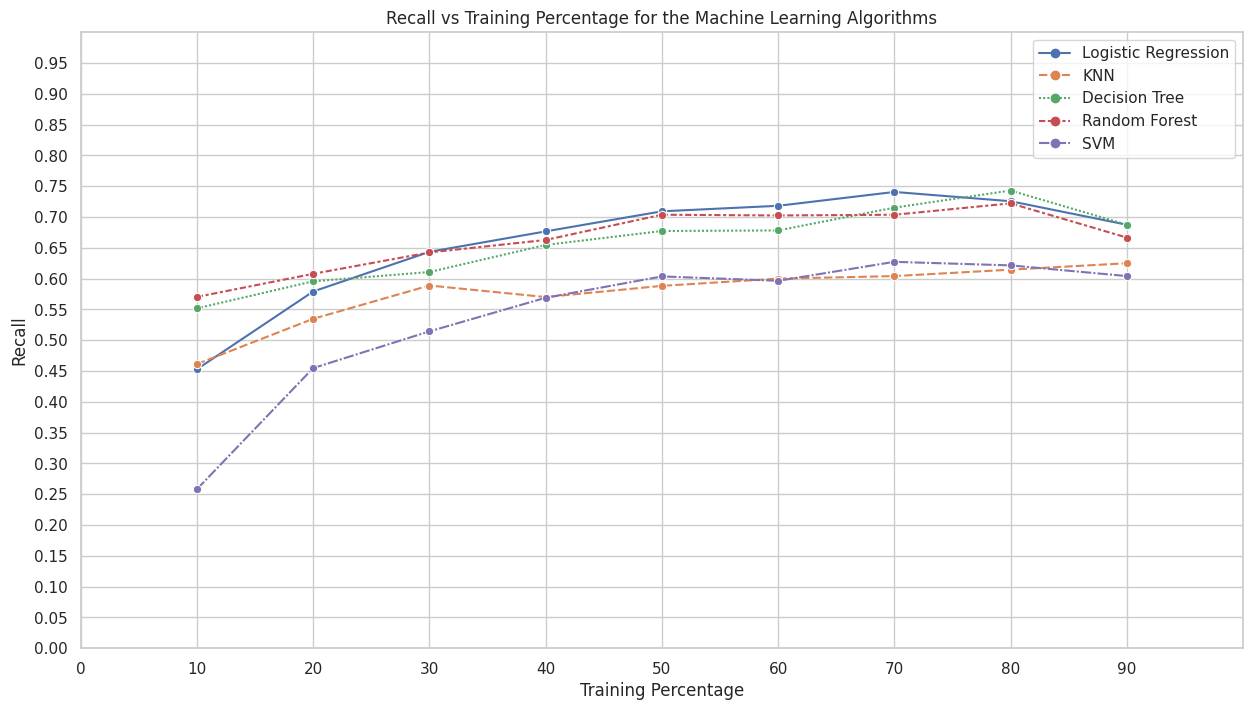

In [ ]:
sns.set(rc={'figure.figsize':(15,8)})
sns.set_style('whitegrid')
g = sns.lineplot(data = recalls, markers= ['o', 'o', 'o', 'o', 'o'])
g.set(xlim = (0,100), ylim = (0,1), xticks = np.arange(0, 100, 10), yticks = np.arange(0, 1, 0.05))
g.set_title("Recall vs Training Percentage for the Machine Learning Algorithms")
g.set_xlabel("Training Percentage")
g.set_ylabel("Recall")

In [ ]:
hidden_units = [2, 4, 6, 8, 10, 12, 14, 16, 18]

In [ ]:
def train_test_nn(X, y, training_percentage, hidden_units) :
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=1-training_percentage, stratify=y, random_state=42)
    trainX = trainX.toarray()
    testX = testX.toarray()
    trainY = np.array(trainY)
    testY = np.array(testY)
    model = Sequential()
    model.add(Input(shape=(trainX.shape[1], ), name='Input-Layer'))
    model.add(Dense(hidden_units, activation='relu', name='Hidden-Layer'))
    model.add(Dense(1, activation='sigmoid', name='Output-Layer'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Accuracy', 'Precision', 'Recall'])
    model.fit(trainX, trainY, batch_size = 10, epochs = 10, verbose=0)
    score = model.evaluate(testX, testY, batch_size = 1, verbose=2)
    return score

In [ ]:
accuracies_nn = []
precisions_nn = []
recalls_nn = []
for ts in training_sizes :
    a = []
    p = []
    r = []
    for hn in hidden_units :
        s = train_test_nn(features, y, ts, hn)
        a.append(s[1])
        p.append(s[2])
        r.append(s[3])
    accuracies_nn.append(a)
    precisions_nn.append(p)
    recalls_nn.append(r)

4500/4500 - 5s - loss: 0.4758 - Accuracy: 0.7124 - precision: 0.0000e+00 - recall: 0.0000e+00 - 5s/epoch - 1ms/step
4500/4500 - 6s - loss: 0.4295 - Accuracy: 0.8433 - precision: 0.9402 - recall: 0.4861 - 6s/epoch - 1ms/step
4500/4500 - 7s - loss: 0.3766 - Accuracy: 0.8344 - precision: 0.9507 - recall: 0.4474 - 7s/epoch - 1ms/step
4500/4500 - 6s - loss: 0.3615 - Accuracy: 0.8576 - precision: 0.9224 - recall: 0.5510 - 6s/epoch - 1ms/step
4500/4500 - 6s - loss: 0.3491 - Accuracy: 0.8584 - precision: 0.9305 - recall: 0.5487 - 6s/epoch - 1ms/step
4500/4500 - 5s - loss: 0.3451 - Accuracy: 0.8653 - precision: 0.9145 - recall: 0.5866 - 5s/epoch - 1ms/step
4500/4500 - 8s - loss: 0.3384 - Accuracy: 0.8638 - precision: 0.9168 - recall: 0.5788 - 8s/epoch - 2ms/step
4500/4500 - 7s - loss: 0.3341 - Accuracy: 0.8653 - precision: 0.9047 - recall: 0.5943 - 7s/epoch - 1ms/step
4500/4500 - 7s - loss: 0.3314 - Accuracy: 0.8658 - precision: 0.8833 - recall: 0.6144 - 7s/epoch - 1ms/step
4000/4000 - 5s - los

In [ ]:
accuracies_nn_df = pd.DataFrame(accuracies_nn, columns=hidden_units, index=training_sizes*100)
precisions_nn_df = pd.DataFrame(precisions_nn, columns=hidden_units, index=training_sizes*100)
recalls_nn_df = pd.DataFrame(recalls_nn, columns=hidden_units, index=training_sizes*100)

In [ ]:
accuracies_nn_df

,2,4,6,8,10,12,14,16,18
10.0,0.712444,0.843333,0.834444,0.857556,0.858444,0.865333,0.863778,0.865333,0.865778
20.0,0.876500,0.880750,0.886250,0.886500,0.894500,0.898750,0.897750,0.895500,0.893000
30.0,0.890571,0.891429,0.903429,0.904000,0.904286,0.902286,0.903429,0.904857,0.901429
40.0,0.896000,0.908000,0.908333,0.909667,0.910667,0.911667,0.911667,0.910000,0.910667
50.0,0.904400,0.913200,0.914800,0.914000,0.915600,0.915600,0.915600,0.915600,0.915200
60.0,0.907000,0.918500,0.919500,0.919500,0.921000,0.920000,0.920000,0.917000,0.919000
70.0,0.923384,0.917388,0.923384,0.920053,0.921386,0.920720,0.922052,0.923384,0.920053
80.0,0.921000,0.915000,0.915000,0.918000,0.916000,0.915000,0.916000,0.917000,0.917000
90.0,0.910000,0.918000,0.922000,0.920000,0.922000,0.918000,0.924000,0.922000,0.922000


Text(0, 0.5, 'Accuracy')

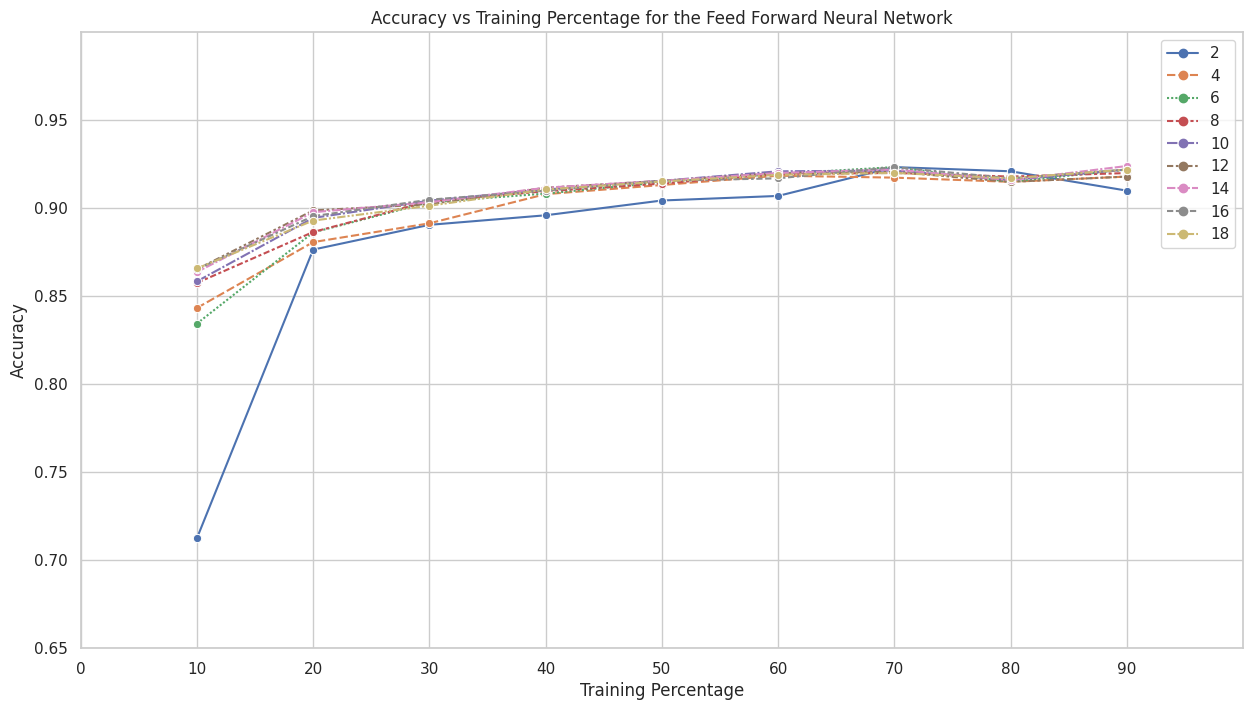

In [ ]:
sns.set(rc={'figure.figsize':(15,8)})
sns.set_style('whitegrid')
g = sns.lineplot(data = accuracies_nn_df, markers= ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o'])
g.set(xlim = (0,100), ylim = (0.65,1), xticks = np.arange(0, 100, 10), yticks = np.arange(0.65, 1, 0.05))
g.set_title("Accuracy vs Training Percentage for the Feed Forward Neural Network")
g.set_xlabel("Training Percentage")
g.set_ylabel("Accuracy")

Text(0, 0.5, 'Precision')

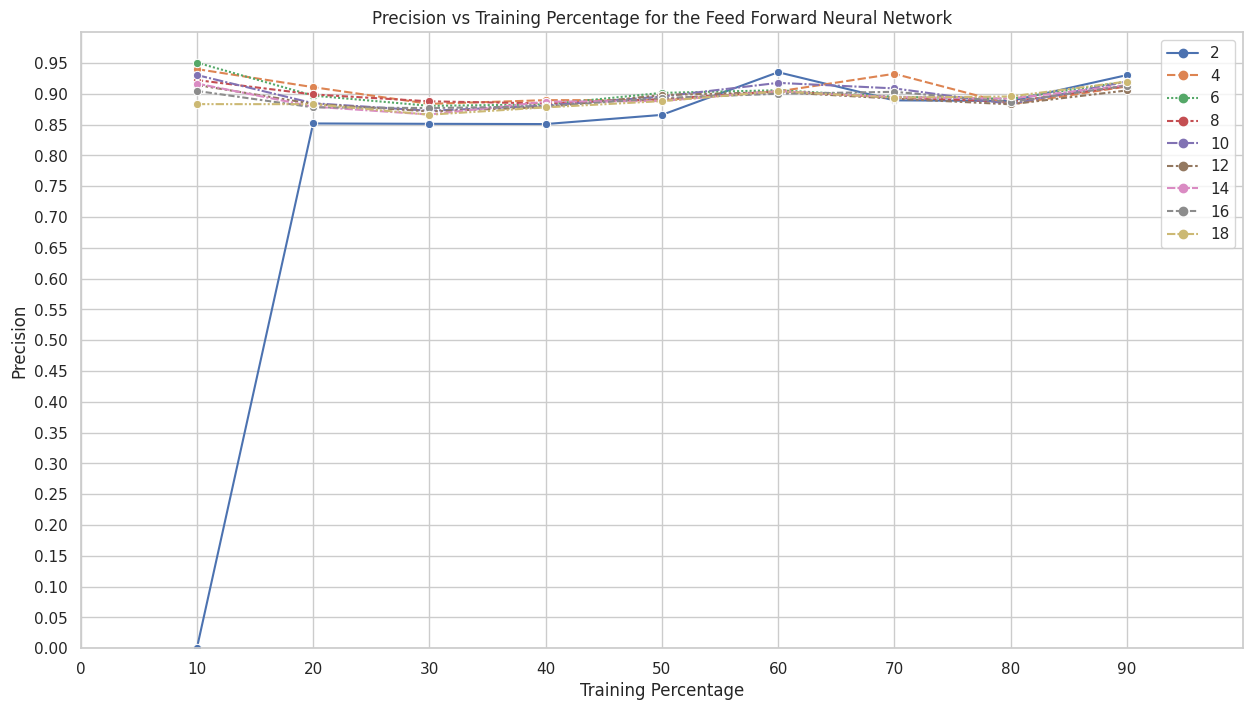

In [ ]:
sns.set(rc={'figure.figsize':(15,8)})
sns.set_style('whitegrid')
g = sns.lineplot(data = precisions_nn_df, markers= ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o'])
g.set(xlim = (0,100), ylim = (0,1), xticks = np.arange(0, 100, 10), yticks = np.arange(0, 1, 0.05))
g.set_title("Precision vs Training Percentage for the Feed Forward Neural Network")
g.set_xlabel("Training Percentage")
g.set_ylabel("Precision")

Text(0, 0.5, 'Recall')

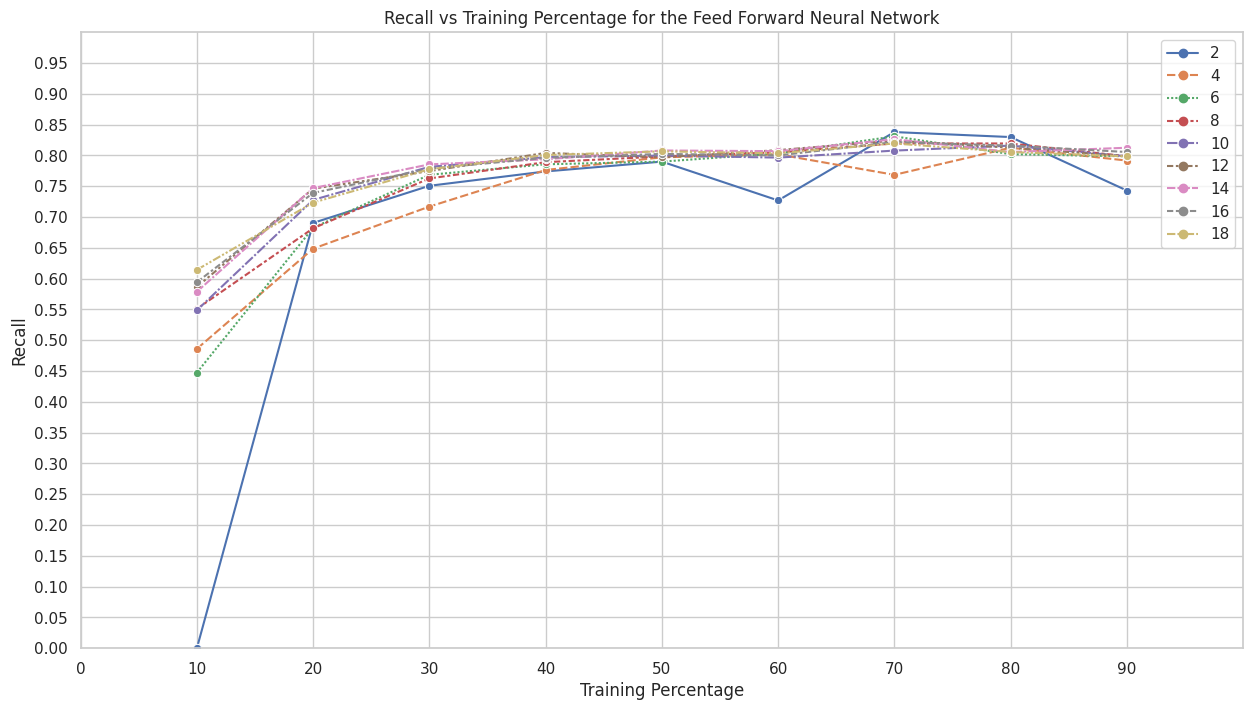

In [ ]:
sns.set(rc={'figure.figsize':(15,8)})
sns.set_style('whitegrid')
g = sns.lineplot(data = recalls_nn_df, markers= ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o'])
g.set(xlim = (0,100), ylim = (0,1), xticks = np.arange(0, 100, 10), yticks = np.arange(0, 1, 0.05))
g.set_title("Recall vs Training Percentage for the Feed Forward Neural Network")
g.set_xlabel("Training Percentage")
g.set_ylabel("Recall")